In [14]:
# just imports
%load_ext autoreload
%autoreload 2

import sys
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils import data
from torch import utils
from torch.optim import Adam

from torchvision import transforms
from torchvision import datasets

import numpy as np

from matplotlib import pyplot as plt
from pandas import read_fwf, DataFrame
from tqdm   import tqdm_notebook as tqdm
import matplotlib.gridspec as gridspec

from scipy.ndimage.interpolation import rotate
from sklearn.model_selection import train_test_split

from sklearn.manifold import TSNE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# local imports
sys.path.append('../')
from VAE.rg_dataset import LRG, BalancedDataSetLRG
from VAE.loss_funcs import VAE_Loss
from VAE import vae_models
import pickle

In [8]:
%%time
data_path = '../data/'
aug=1

lrg_datasets   = pickle.load( open( "lrg.p", "rb" ) )

normal_data_loader = utils.data.DataLoader(lrg_datasets['full'],
                                           batch_size=128, shuffle=False)

data_loader_lrg   = utils.data.DataLoader(lrg_datasets['train'], 
                                          batch_size=128, shuffle=True)

CPU times: user 22.9 ms, sys: 347 ms, total: 370 ms
Wall time: 941 ms


In [131]:
from matplotlib import offsetbox
from skimage.transform import rescale
def plot_embedding(X, Y, colors, labels, title=None, sz=100):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(10,5))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.scatter(X[i, 0], X[i, 1])

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(Y.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
#             if np.min(dist) < 4e-3:
# #                 don't show points that are too close
#                 continue
            shown_images = np.r_[shown_images, [X[i]]]
            img = rescale(Y[i], (sz/Y[i].shape[0], sz/Y[i].shape[1]), mode='reflect', multichannel=False, anti_aliasing=False)
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(img, cmap=plt.cm.gray_r),
                X[i], bboxprops =dict(lw=1,edgecolor=colors[labels[i]]))
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [132]:
class VAE(nn.Module):
    def __init__(self, lt_dim=4, k=None, batch_norm=True):
        super(VAE, self).__init__()
        self.k = k
        n_layers = len(self.k)
        encoder_layers = []
        decoder_layers = []
        
        for i in range( n_layers -1) :
            in_c, out_c = self.k[i], self.k[i + 1]
            if(in_c == 'M'): continue
            stride = 1
            if out_c == 'M':
                stride = 2
                i += 1
                out_c = self.k[i + 1]
            layer = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, stride=stride)
            encoder_layers.append(layer)
            if batch_norm:
                encoder_layers.append(nn.BatchNorm2d(out_c))
            encoder_layers.append(nn.ReLU(inplace=True))
        self.encoder = nn.Sequential(*encoder_layers)
        
        for i in range(n_layers - 1, 0, -1):
            in_c, out_c = self.k[i], self.k[i - 1]
            if(in_c == 'M'): continue
            stride = 1
            output_padding=0
            if out_c == 'M':
                stride = 2
                i -= 1
                out_c = self.k[i - 1]
                output_padding=1
                
            layer = nn.ConvTranspose2d(in_c, out_c, kernel_size=3, padding=1, 
                                       output_padding=output_padding, stride=stride)
            decoder_layers.append(layer)
            if batch_norm:
                decoder_layers.append(nn.BatchNorm2d(out_c))
            decoder_layers.append(nn.ReLU(inplace=True))

        self.decoder = nn.Sequential(*decoder_layers[:-1])
        
        self.fc_mu = nn.Sequential(
                      nn.Linear(self.k[-1]*2*2, lt_dim*2),
                      nn.Linear(lt_dim*2, lt_dim)
        )
        self.fc_ep = nn.Sequential(
                      nn.Linear(self.k[-1]*2*2, lt_dim*2),
                      nn.Linear(lt_dim*2, lt_dim)
        )
        
        self.fc_dc = nn.Linear(lt_dim, self.k[-1]*2*2)
        
    def encode(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(-1, self.k[-1]*2*2)
        return self.fc_mu(encoded), self.fc_ep(encoded)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        if self.training :
            return mu + eps*std
        return mu

    def decode(self, x):
        x = F.relu(self.fc_dc(x))
        x = x.view(-1, self.k[-1], 2, 2) #reshape
        return torch.sigmoid(self.decoder(x))
    
    def forward(self, x):
        mu, var = self.encode(x)
        z = self.reparameterize(mu, var)
        d = self.decode(z)
        return d, mu, var

model = torch.load('SimpleVAE')

In [133]:
model.eval()
enc_vals = []
labels = []
images = []
j = 1
with torch.no_grad():
    for i, (data, target) in enumerate(data_loader_lrg):
        for d in data.tolist():
            images.append(d)
        e = model.encode(data.to('cuda'))[0]
        enc_vals += (e.to('cpu').tolist())
        labels += target.tolist()
        j -= 1
        if j == 0:
            break
enc_vals = np.array(enc_vals)
images = np.array(images)

X = enc_vals
Y = np.array(labels)
print(len(labels))

128


In [134]:
# images[:,0].shape

In [137]:
X_embedded = TSNE(n_components=2).fit_transform(X)

<IPython.core.display.Javascript object>


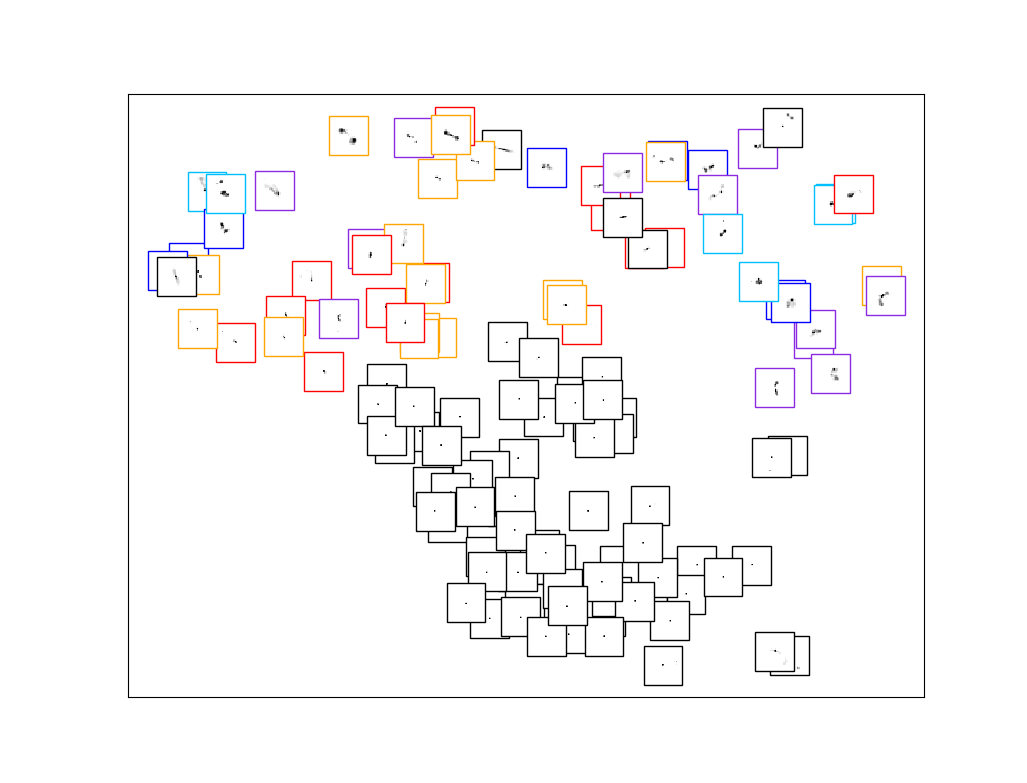

In [139]:
%matplotlib notebook
colors=['black', 'red', 'orange','blueviolet','blue', 'deepskyblue']
plot_embedding(X_embedded, images[:,0], colors=colors, labels=labels, sz=20)